## Read

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn

from glob import iglob

In [2]:
def process_label(df, path):
    df['label'] = 2
    path = path.rstrip('.csv')
    path = f'{path}.txt'
    with open(path, 'r') as fr:
        lines = fr.readlines()
        for i, line in enumerate(lines[:-1]):
            line = line.rstrip('\n').split(',')
            j, l = int(line[0]), int(line[1])
            k = int(lines[i+1].split(',')[0]) - 1
            if k<j:
                print(k)
            df.loc[j:k, 'label'] = l

        line = lines[-1].rstrip('\n').split(',')
        j, l = int(line[0]), int(line[1])
        df.loc[j:, 'label'] = 1


def process_feature(df):
    df['ln_pts'] = np.log(df['pts']+1)
    df['ln_dyn'] = np.log(df['pts_dyn']+1)
    df['ln_sta'] = np.log(df['pts']-df['pts_dyn']+1)

    df['z_iqr'] = df['z_q3'] - df['z_q1']

    df['range'] = np.sqrt(np.square(df['x_c'])+np.square(df['y_c']))

    df['dx'] = df['x_c'].diff().fillna(0)
    df['dy'] = df['y_c'].diff().fillna(0)
    df['dist'] = np.sqrt(np.square(df['dx'])+np.square(df['dy']))

    df.reset_index(inplace=True)


In [ ]:
dfs = []

for path in iglob(r'C:/Users/pontosense/Downloads/Target/*.csv'):
    path = path.replace('\\', '/')
    df = pd.read_csv(path, index_col=0)

    process_label(df, path)
    process_feature(df)

    n = round(df.shape[0] / 120)
    print(path.split('/')[-1], n, '{:.1%}'.format(df['label'].mean()))

    df = df[
        ['ln_pts', 'z_iqr', 'z_std', 'z_c', 'range', 'l_r', 's_r', 'dist', 'label']
    ].astype('float32').values
    for i in range(n):
        dfs.append(df)

ATR_GN_P2-240527-30019-2025-08-31-00-1384880-1388055.csv 24 98.1%
ATR_GN_P2-240527-30019-2025-09-02-00-3097855-3098844.csv 8 98.0%
ATR_GN_P2-240527-30019-2025-09-02-09-3427349-3428726.csv 7 100.0%
ATR_GN_P2-240601-00069-2025-08-27-15-181634-185130.csv 28 77.2%
ATR_GN_P2-240601-00069-2025-08-29-04-713100-716599.csv 29 98.6%
ATR_GN_P4-241029-00016-2025-09-01-07-2584784-2591384.csv 49 97.7%
ATR_GN_P4-250120-00138-2025-09-04-15-372127-373946.csv 14 95.0%
ATR_GN_P4-250120-00138-2025-09-07-15-2969150-2970732.csv 13 99.1%
ATR_GN_P4-250120-00138-2025-09-07-20-3155534-3159779.csv 20 7.1%
ATR_GN_P4-250120-00172-2025-09-01-03-7698018-7703053.csv 18 100.0%
P1-TP5-0528test-170695-173549.csv 17 99.8%
P1-TP5-0528test-199959-202507.csv 12 95.8%
P1-TP5-0528test-203583-205322.csv 13 99.4%


## Dataset & Dataloader

In [3]:
from torch.utils.data import (
    Dataset,
    DataLoader
)

In [5]:
class TrainDataset(Dataset):

    def __init__(self, dfs):
        self.dfs = dfs

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, idx):
        arr = self.dfs[idx]
        jdx = np.random.choice(arr.shape[0]-79, 1)[0]
        batch = arr[jdx:jdx+80, :-1]
        label = arr[jdx:jdx+80, -1]
        return batch, label


In [6]:
np.random.seed(2025)
torch.manual_seed(2025)

train_ds = TrainDataset(dfs)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

## Model

In [4]:
from torchinfo import summary

from layers import (
    EMA,
    Transpose
)

In [5]:
hs = 64

model = nn.Sequential(
    nn.Linear(8, hs, bias=False),
    Transpose(),
    nn.ReLU6(),
    EMA(hs, length=80),
    Transpose(),
    nn.ReLU6(),
    nn.Linear(hs, 1, bias=False)
)

summary(model, (2, 80, 8), col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Sequential                               [2, 80, 8]                [2, 80, 1]                --
├─Linear: 1-1                            [2, 80, 8]                [2, 80, 64]               512
├─Transpose: 1-2                         [2, 80, 64]               [2, 64, 80]               --
├─ReLU6: 1-3                             [2, 64, 80]               [2, 64, 80]               --
├─EMA: 1-4                               [2, 64, 80]               [2, 64, 80]               128
├─Transpose: 1-5                         [2, 64, 80]               [2, 80, 64]               --
├─ReLU6: 1-6                             [2, 80, 64]               [2, 80, 64]               --
├─Linear: 1-7                            [2, 80, 64]               [2, 80, 1]                64
Total params: 704
Trainable params: 704
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.01
For

## Train

In [6]:
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    BinaryAccuracy,
    BinaryAUROC
)

In [7]:
# criterion
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=.1**.5)

metric = MetricCollection({'acc':BinaryAccuracy(), 'auc':BinaryAUROC()})

In [11]:
epochs = 300
step = 0

model.train()

for epoch in range(epochs):

    for batch, label in train_dl:
        logit = model(batch).squeeze(-1)
        loss = loss_fn(logit, label)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        proba = torch.sigmoid(logit)
        metric.update(proba, label)
        step += 1
    scheduler.step()

    if (epoch % 10 == 1) or (epoch==epochs-1):
        res = metric.compute()
        print(f'epoch {epoch+1:>2d} - acc: {res["acc"]:.4f} - auc: {res["auc"]:.4f}')
        metric.reset()
        torch.save(model.state_dict(), f'./ckpt/epoch{epoch}-{res["auc"]:.4f}.pth')


epoch  2 - acc: 0.8713 - auc: 0.6142
epoch 12 - acc: 0.8862 - auc: 0.7269
epoch 22 - acc: 0.8822 - auc: 0.8705
epoch 32 - acc: 0.8844 - auc: 0.8996
epoch 42 - acc: 0.8874 - auc: 0.9022
epoch 52 - acc: 0.8883 - auc: 0.9096
epoch 62 - acc: 0.8948 - auc: 0.9173
epoch 72 - acc: 0.8953 - auc: 0.9194
epoch 82 - acc: 0.9093 - auc: 0.9220
epoch 92 - acc: 0.9199 - auc: 0.9289
epoch 102 - acc: 0.9305 - auc: 0.9361
epoch 112 - acc: 0.9326 - auc: 0.9327
epoch 122 - acc: 0.9319 - auc: 0.9333
epoch 132 - acc: 0.9320 - auc: 0.9186
epoch 142 - acc: 0.9319 - auc: 0.9304
epoch 152 - acc: 0.9333 - auc: 0.9348
epoch 162 - acc: 0.9360 - auc: 0.9331
epoch 172 - acc: 0.9346 - auc: 0.9289
epoch 182 - acc: 0.9294 - auc: 0.9273
epoch 192 - acc: 0.9385 - auc: 0.9409
epoch 202 - acc: 0.9403 - auc: 0.9287
epoch 212 - acc: 0.9334 - auc: 0.9346
epoch 222 - acc: 0.9451 - auc: 0.9375
epoch 232 - acc: 0.9358 - auc: 0.9253
epoch 242 - acc: 0.9354 - auc: 0.9327
epoch 252 - acc: 0.9342 - auc: 0.9301
epoch 262 - acc: 0.935

In [15]:
model

Sequential(
  (0): Linear(in_features=8, out_features=64, bias=False)
  (1): Transpose()
  (2): ReLU6()
  (3): EMA(in_chn=64, length=80)
  (4): Transpose()
  (5): ReLU6()
  (6): Linear(in_features=64, out_features=1, bias=False)
)

In [14]:
model[3].alpha.data.flatten()

tensor([0.1497, 0.5854, 0.2912, 0.5000, 0.8639, 0.2013, 0.4864, 0.5199, 0.6250,
        0.4718, 0.9034, 0.8661, 0.5589, 0.5672, 0.8898, 0.5437, 0.2005, 0.6158,
        0.5408, 0.0230, 0.9072, 0.4784, 0.8509, 0.4257, 0.5043, 0.8145, 0.1796,
        0.5348, 0.8724, 0.5836, 0.5419, 0.8934, 0.5584, 0.9504, 0.6122, 0.9176,
        0.2484, 0.4015, 0.7118, 0.1777, 0.6884, 0.2774, 0.5411, 0.6919, 0.4585,
        0.4447, 0.4474, 0.3540, 0.4767, 0.4748, 0.8927, 0.8342, 0.8278, 0.6744,
        0.9054, 0.6385, 0.6868, 0.5670, 0.3053, 0.5882, 0.8954, 0.7668, 0.2954,
        0.6239])

## Test

In [8]:
dfs = []

for path in iglob(r'C:/Users/pontosense/Downloads/Target/test/*.csv'):
    path = path.replace('\\', '/')
    df = pd.read_csv(path, index_col=0)

    process_label(df, path)
    process_feature(df)

    n = df.shape[0] // 80
    print(path.split('/')[-1], n, '{:.1%}'.format(df['label'].mean()))

    df = df[
        ['ln_pts', 'z_iqr', 'z_std', 'z_c', 'range', 'l_r', 's_r', 'dist', 'label']
    ].astype('float32').values
    for i in range(n):
        dfs.append(df[i*80:(i+1)*80])

ATR_GN_P2-240527-30019-2025-09-02-01-3123914-3124287.csv 4 100.0%
ATR_GN_P2-240527-30019-2025-09-03-11-4351701-4352882.csv 4 31.6%
P1-TP5-0528test-185780-186966.csv 11 100.0%


In [9]:
len(dfs)

19

In [10]:
class TestDataset(Dataset):

    def __init__(self, dfs):
        self.dfs = dfs

    def __len__(self):
        return len(self.dfs)

    def __getitem__(self, idx):
        arr = self.dfs[idx]
        batch = arr[:, :-1]
        label = arr[:, -1]
        return batch, label

In [11]:
test_ds = TestDataset(dfs)
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=0, drop_last=False)

In [21]:
model.eval()

for path in iglob('ckpt/*.pth'):
    ckpt = torch.load(path)
    model.load_state_dict(ckpt)
    s = path.split('\\')[-1]

    for batch, label in test_dl:
        with torch.no_grad():
            logit = model(batch).squeeze(-1)
            proba = torch.sigmoid(logit)

        metric.update(proba, label)

    res = metric.compute()
    print(f'{s}  - acc: {res["acc"]:.4f} - auc: {res["auc"]:.4f}')
    metric.reset()

ckpt\epoch1-0.6142.pth  - acc: 0.8401 - auc: 0.8701
ckpt\epoch101-0.9361.pth  - acc: 0.9033 - auc: 0.9040
ckpt\epoch11-0.7269.pth  - acc: 0.8401 - auc: 0.8801
ckpt\epoch111-0.9327.pth  - acc: 0.9046 - auc: 0.9036
ckpt\epoch121-0.9333.pth  - acc: 0.9072 - auc: 0.9021
ckpt\epoch131-0.9186.pth  - acc: 0.9072 - auc: 0.9017
ckpt\epoch141-0.9304.pth  - acc: 0.9066 - auc: 0.9002
ckpt\epoch151-0.9348.pth  - acc: 0.9059 - auc: 0.8998
ckpt\epoch161-0.9331.pth  - acc: 0.9053 - auc: 0.8993
ckpt\epoch171-0.9289.pth  - acc: 0.9066 - auc: 0.8993
ckpt\epoch181-0.9273.pth  - acc: 0.9066 - auc: 0.8991
ckpt\epoch191-0.9409.pth  - acc: 0.9053 - auc: 0.8991
ckpt\epoch201-0.9287.pth  - acc: 0.9066 - auc: 0.8992
ckpt\epoch21-0.8705.pth  - acc: 0.8401 - auc: 0.9196
ckpt\epoch211-0.9346.pth  - acc: 0.9053 - auc: 0.8990
ckpt\epoch221-0.9375.pth  - acc: 0.9053 - auc: 0.8991
ckpt\epoch231-0.9253.pth  - acc: 0.9053 - auc: 0.8991
ckpt\epoch241-0.9327.pth  - acc: 0.9053 - auc: 0.8991
ckpt\epoch251-0.9301.pth  - acc:

In [12]:
model.eval()

path = 'ckpt/epoch161-0.9331.pth'
ckpt = torch.load(path)
s = path.split('//')[-1]
model.load_state_dict(ckpt)

probas = []
labels = []
for batch, label in test_dl:
    with torch.no_grad():
        logit = model(batch).squeeze(-1)
        proba = torch.sigmoid(logit)

    labels.append(label.flatten().numpy())
    probas.append(proba.flatten().numpy())
    metric.update(proba, label)

res = metric.compute()
print(f'{s}  - acc: {res["acc"]:.4f} - auc: {res["auc"]:.4f}')
metric.reset()

ckpt/epoch161-0.9331.pth  - acc: 0.9053 - auc: 0.8993


In [13]:
probas = np.concat(probas)
y_true = np.concat(labels)

In [14]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, probas>0.6)

array([[ 170,   73],
       [  76, 1201]])

In [ ]:
[(0, 2.5), (2.5, 3), (5.5, 2)]

In [15]:
arr = np.asarray([1, 1, 1, 0, 0, 0, 1, 1])

def pre_broken_barh(arr):
    diff = np.where(np.diff(arr)!=0)[0]
    colors = []
    xranges = []

    for i, j in enumerate(np.r_[-1, diff]):
        colors.append(f'C{arr[j+1]}')
        if i == 0:
            xranges.append((0, float(diff[0])+0.5))
            continue
        elif i < len(diff):
            i = float(diff[i])
        else:
            i = float(len(arr)-1)

        j = float(j)
        xranges.append((j+.5, i-j))
    return xranges, colors


In [23]:
df = pd.read_csv('C:/Users/pontosense/Downloads/Target/test2/ATR_GN_P2-240527-30019-2025-09-02-01-3123914-3124977_res.csv').loc[:320-1]
df = pd.concat(
    [df,
    pd.read_csv('C:/Users/pontosense/Downloads/Target/test2/ATR_GN_P2-240527-30019-09-03-11-4351701-4353067_res.csv').loc[:320-1]],
    ignore_index=True
)
df = pd.concat(
    [df,
    pd.read_csv('C:/Users/pontosense/Downloads/Target/test2/P1-TP5-0528test-185780-186966_res.csv').loc[:880-1]],
    ignore_index=True
)


array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

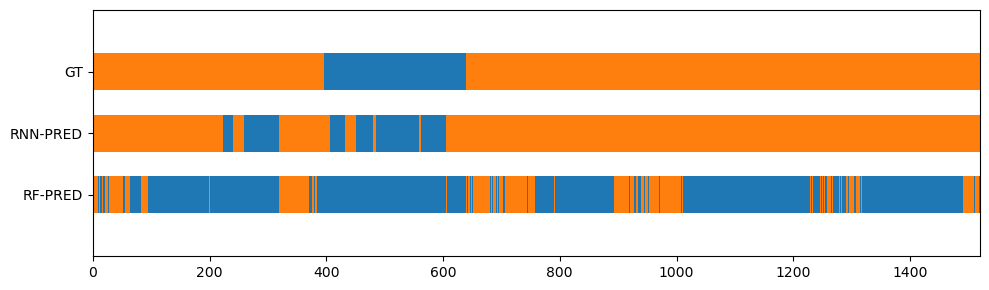

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 3))

xranges, colors = pre_broken_barh(df['pred'].astype(int))
ax.broken_barh(xranges,  (.2, .6), facecolors=colors)
xranges, colors = pre_broken_barh((probas>0.6).astype(int))
ax.broken_barh(xranges,  (1.2, .6), facecolors=colors)
xranges, colors = pre_broken_barh(y_true.astype(int))
ax.broken_barh(xranges,  (2.2, .6), facecolors=colors)

# 设置坐标范围与样式
ax.set_xlim(0, len(y_true))
ax.set_ylim(-0.5, 3.5)
ax.set_yticks([0.5, 1.5, 2.5], ['RF-PRED', 'RNN-PRED', 'GT'])
# ax.set_xlabel("Time")

plt.tight_layout()
plt.show()